Importamos cositas.

In [74]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import time
import numpy as np
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable, Gate
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.circuits.noise_model import (GateCriteria, NoiseModel,
                                         ObservableCriteria)
from braket.circuits.noises import (AmplitudeDamping, BitFlip, Depolarizing,
                                    PauliChannel, PhaseDamping, PhaseFlip,
                                    TwoQubitDepolarizing)

Creamos un estado singlete: $$|\psi\rangle = \frac{1}{\sqrt{2}}(|01\rangle - |10\rangle)$$

Tiene la propiedad peculiar de que si Alice y Bob miden en la misma dirección (para cualquier dirección), los resultados van a estar anti-correlacionados. Por ejemplo, siempre que Alice mida y obtenga cero, Bob va a obtener 1, y si Alice obtiene 1, Bob va a obtener cero.

In [ ]:
singlet = Circuit() # Creo que el circuito
singlet.x(0) # Aplique una compuerta X al qubit 0 
singlet.x(1) # Aplique una compuerta X al qubit 1
singlet.h(0) # Aplique Hadamard al qubit 0
singlet.cnot(0,1) # Aqplique Control not entre 0 y 1 (con uno como control)

### Si no aplican nada, la medición se realiza en las direcciones ZZ (Z Alice y Z Bob).

### Medimos en direcciones XX (agregar esto):
# singlet.h(0)
# singlet.h(1)

### Medimos en direcciones YY (agregar esto):
# singlet.si(0)
# singlet.h(0)
# singlet.si(1)
# singlet.h(1)

print(singlet)

T  : │  0  │  1  │  2  │
      ┌───┐ ┌───┐       
q0 : ─┤ X ├─┤ H ├───●───
      └───┘ └───┘   │   
      ┌───┐       ┌─┴─┐ 
q1 : ─┤ X ├───────┤ X ├─
      └───┘       └───┘ 
T  : │  0  │  1  │  2  │


El circuito de arriba genera el estado:
$$|\psi\rangle = \frac{1}{\sqrt{2}}(|01\rangle-|10\rangle)$$
Ahora simulamos la estadística de este estado:

Counter({'10': 5057, '01': 4943})
{'01': 0.4943, '10': 0.5057}


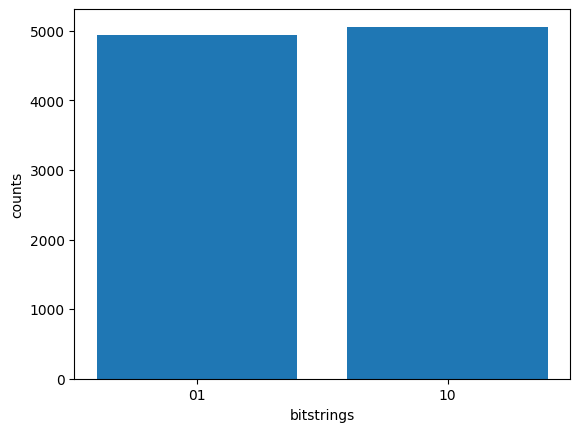

In [76]:
# set up device: Local Simulator
device = LocalSimulator() # Simulador local 

# Definimos la tarea a correr

S = 10000

task = device.run(singlet, shots = S ) # Correr mi circuito "singlet" en el dispositivo "device" (repetir 10 veces).

# Extraemos el resultado de la corrida

result = task.result() # Extraigo los resultados de la tarea ejecutada. 

# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

probas = { '01': counts['01']/S, '10': counts['10']/S }

print(probas)

Ahora vamos a simular una computadora ruidosa. Hay distintos tipos de ruido.
Tenemos que cambiar el backend.

In [ ]:
singlet = Circuit()
singlet.x(0)
singlet.x(1)
singlet.h(0)
singlet.cnot(0,1)

### Medimos en direcciones XX (agregar esto):
# singlet.h(0)
# singlet.h(1)

### Medimos YY:
# singlet.si(0)
# singlet.h(0)
# singlet.si(1)
# singlet.h(1)

noise_model = NoiseModel() # Creamos un modelo de ruido.

# noise_model.add_noise(Depolarizing(0.0005), GateCriteria(Gate.H))
# noise_model.add_noise(Depolarizing(0.004), GateCriteria(Gate.CNot))

noise_model.add_noise(Depolarizing(0.02), GateCriteria(Gate.H)) # Agregamos ruido en la compuerta H
noise_model.add_noise(Depolarizing(0.004), GateCriteria(Gate.CNot)) # Agregamos ruido en la compuerta Cnot

#noise_model.add_noise(BitFlip(0.000002), criteria=GateCriteria())
#noise_model.add_noise(AmplitudeDamping(0.000000001), GateCriteria(qubits=[0,1,2]))
# noise_model.add_noise(PauliChannel(0.1, 0.2, 0.3), GateCriteria(gates=Gate.X, qubits=1))

singlet_ruidoso = noise_model.apply(singlet)

# attach the result types
singlet_ruidoso.probability()
# singlet_ruidoso.expectation(observable = Observable.Z()@Observable.X(),target=[0,1])
# attach the density matrix with target=[0,1]
# singlet_ruidoso.density_matrix(target=[0,1])

print(singlet_ruidoso)

T  : │  0  │         1          │          2          │ Result Types  │
      ┌───┐ ┌───┐ ┌────────────┐       ┌─────────────┐ ┌─────────────┐ 
q0 : ─┤ X ├─┤ H ├─┤ DEPO(0.02) ├───●───┤ DEPO(0.004) ├─┤ Probability ├─
      └───┘ └───┘ └────────────┘   │   └─────────────┘ └──────┬──────┘ 
      ┌───┐                      ┌─┴─┐ ┌─────────────┐ ┌──────┴──────┐ 
q1 : ─┤ X ├──────────────────────┤ X ├─┤ DEPO(0.004) ├─┤ Probability ├─
      └───┘                      └───┘ └─────────────┘ └─────────────┘ 
T  : │  0  │         1          │          2          │ Result Types  │


Counter({'01': 505, '10': 488, '11': 4, '00': 3})


Text(0, 0.5, 'counts')

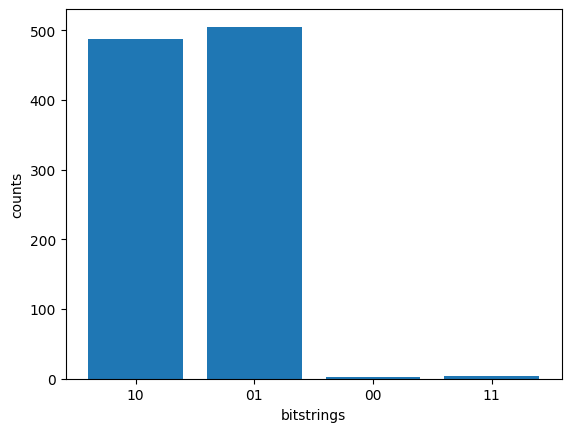

In [78]:
# set up device: Local Simulator
device = LocalSimulator(backend="braket_dm")

# run circuit
task = device.run(singlet_ruidoso, shots=1000)

# Obtenemos el resultado
result = task.result()

# print('- The reduced Density Matrix is: ')
# print(result.values[0])
#Calculamos las cuentas
counts = result.measurement_counts
# # print counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

In [79]:
from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, Gate, Noise, Observable, Instruction

import boto3

from braket.devices import LocalSimulator

import numpy as np
import matplotlib.pyplot as plt
import itertools
from itertools import permutations

In [80]:
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1")

# device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
          
# device = LocalSimulator(backend="braket_dm")

aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
print(aws_account_id) 

NoRegionError: You must specify a region.

In [ ]:
my_bucket = "amazon-braket-holik-2023-01-24" # the name of the bucket
my_prefix = "Aria_1" # the name of the folder in the bucket
s3_location = (my_bucket, my_prefix)

In [ ]:
device.run_batch([singlet]], s3_location, shots=S)